In [1]:
# pip install psycopg2

In [2]:
import psycopg2 as ps
import pandas as pd
from IPython.display import display
from ipywidgets import Dropdown
from ipywidgets import DatePicker

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
%matplotlib inline

# Для отключения предупреждений 
import warnings

In [3]:
from IPython.display import display,HTML
HTML('''<button style="align: center; margin:0 auto; display: block; background-color: #4CAF50;  color: white;  border: 2px solid #4CAF50; /* Green */" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle();"><text style = background-color: #4CAF50;>Нажми меня</text></button>''')

In [4]:
conn = ps.connect(host="158.160.52.106", port = 5432, database="postgres", user="student", 
                  password="JvLda93aA")

In [5]:
# Отключаем предупреждения 
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [6]:
df_funnel = pd.read_sql('''

SELECT *
FROM (
    SELECT * FROM (
         --Зашли на сайт
        (SELECT DISTINCT
        visit_dttm,
        client_rk                             AS client_1,
        EXTRACT(MONTH FROM visit_dttm)        AS month,
        EXTRACT(DAY FROM visit_dttm)          AS day_1
        FROM msu_analytics.client
        ORDER BY month ASC
        ) as step_1

        LEFT JOIN

        --Зарегистрировались
        (SELECT
        Registration_dttm,
        account_rk                             AS account_2,
        client_rk                              AS client_2,
        EXTRACT(MONTH FROM Registration_dttm)  AS month_2,
        EXTRACT(DAY FROM Registration_dttm)    AS day_2
        FROM msu_analytics.Account
        ORDER BY month_2 ASC
        ) as step_2

        ON 

        (step_1.client_1 = step_2.client_2)
        AND
        (step_1.visit_dttm <= step_2.Registration_dttm)


        LEFT JOIN

        --Оставили заявку на игру
        (SELECT 
        Application_dttm,
        account_rk                             AS account_3,
        game_rk                                AS game_3,
        EXTRACT(MONTH FROM Application_dttm)   AS month_3,
        EXTRACT(DAY FROM Application_dttm)     AS day_3
        FROM msu_analytics.Application
        ORDER BY month_3 ASC
        ) as step_3

        ON 

        (step_2.account_2 = step_3.account_3)
        AND
        (step_2.Registration_dttm <= step_3.Application_dttm)


        LEFT JOIN

        --Пришли на игру
        (SELECT 
        Game_dttm,
        game_rk                                AS game_4,
        EXTRACT(MONTH FROM Game_dttm)          AS month_4,
        EXTRACT(DAY FROM Game_dttm)            AS day_4
        FROM msu_analytics.Game
        WHERE game_flg = 1
        ORDER BY month_4 ASC
        ) as step_4

        ON 

        (step_3.game_3 = step_4.game_4)
        AND
        (step_3.Application_dttm <= step_4.Game_dttm)
        
        LEFT JOIN
        
        --Получаю заявки на регистрацию тех, кто пришел
        (SELECT 
        account_rk                            AS account_5,
        game_rk                               AS game_5
        FROM msu_analytics.Application
        ) as step_5
        
        ON 

        (step_4.game_4 = step_5.game_5)
        AND
        (step_3.account_3 = step_5.account_5)
        
        LEFT JOIN
        
                
        --Получаю заявки на регистрацию всех
        (SELECT 
        account_rk                            AS account_6,
        game_rk                               AS game_6
        FROM msu_analytics.Application
        ) as step_6
        
        ON 

        (step_4.game_4 = step_6.game_6)
        
    )

--     ORDER BY week
) as funnel

Union all
SELECT  '2023-01-05',null,3.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,4.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,5.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,6.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,7.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,8.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Order BY month


    ''', con=conn)

In [7]:
data_count = df_funnel.groupby(["month"]).nunique ()

In [8]:
data_all = data_count.drop(
    columns = ['day_1', 'client_2', 'month_2', 'day_2', 'month_3', 'day_3', 'month_4', 'day_4', 'game_3', 'visit_dttm',
               'registration_dttm', 'application_dttm', 'game_dttm', 'game_5', 'game_4', 'game_6']
    ,axis = 1)

data_all = data_all.assign(share_1 = round(data_count.client_2 * 100 / data_count.client_1, 2))
data_all = data_all.assign(share_2 = round(data_count.account_3 * 100 / data_count.client_2, 2))
data_all = data_all.assign(share_3 = round(data_count.account_5 * 100 / data_count.account_3, 2))

data_all['share_3'] = data_all['share_3']. fillna (0)
data_all['share_2'] = data_all['share_2']. fillna (0)
data_all['share_1'] = data_all['share_1']. fillna (0)

data_all.rename(columns = {'client_1':'Зашли на сайт', 'account_2':'Зарегистрировались',  
                           'account_3':'Оставили заявку','account_5':'Пришли на игру', 'account_6':'Всего пришли на игру'
                          }, inplace = True )

In [9]:
data_set = data_all.reset_index()
data_set = data_set.assign(first = data_set['Пришли на игру'])
data_set = data_set.assign(second = data_set['Оставили заявку'] - data_set['Пришли на игру'])
data_set = data_set.assign(third = data_set['Зарегистрировались'] - data_set['Оставили заявку'])
data_set = data_set.assign(fourth = data_set['Зашли на сайт'] - data_set['Зарегистрировались'])
data_set = data_set.drop(columns = ['Зашли на сайт', 'Зарегистрировались', 'Оставили заявку', 
                                    'Пришли на игру', 'Всего пришли на игру'],axis = 1)

# Воронка по месяцам

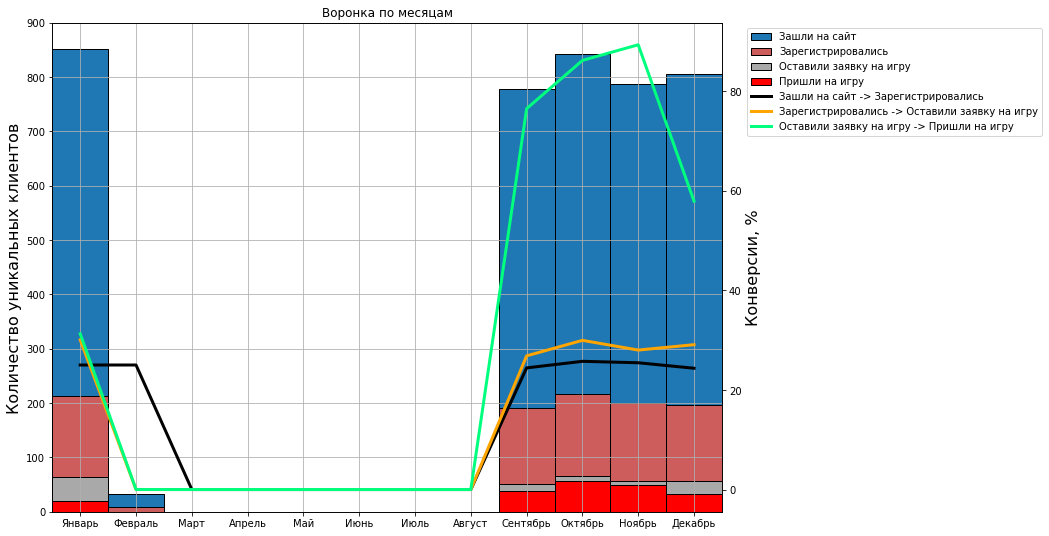

In [10]:
# размерность по оси х
index = np.arange(13)

# Размеры графика
plt.figure(figsize=(12,9))

# График с накоплениями
p1 = plt.bar(data_set['month'], data_set['first'], bottom=0, width=1, edgecolor='k', color = 'r')
p2 = plt.bar(data_set['month'], data_set['second'], bottom=data_set['first'], width=1, edgecolor='k', color = 'darkgray')
p3 = plt.bar(data_set['month'], data_set['third'], bottom=data_set['second'] + data_set['first'], width=1, edgecolor='k', color = 'indianred')
p4 = plt.bar(data_set['month'], data_set['fourth'], bottom=data_set['third'] + data_set['second'] + data_set['first'], width=1, edgecolor='k')
plt.ylabel('Количество уникальных клиентов', color='black', fontsize= 16 )
plt.title('Воронка по месяцам')
plt.xticks(index,['','Январь', 'Февраль', 'Март','Апрель', 'Май', 'Июнь','Июль', 'Август',
                                    'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.ylim(0, 900)
plt.xlim(.5, 12.5)
plt.grid()

# Вторая ось для У (конверсия)
plt.twinx()
plt.ylabel('Конверсии, %', color='black', fontsize= 16 ) 
k1 = plt.plot(data_set['month'], data_set['share_1'], linewidth= 3, color='black')  
k2 = plt.plot(data_set['month'], data_set['share_2'], linewidth= 3,  color='orange')
k3 = plt.plot(data_set['month'], data_set['share_3'], linewidth= 3,  color='springgreen')        
    
plt.legend((p4[0], p3[0], p2[0], p1[0], k1[0], k2[0], k3[0]),('Зашли на сайт', 'Зарегистрировались', 'Оставили заявку на игру',
                                                              'Пришли на игру', 'Зашли на сайт -> Зарегистрировались',
                                                             'Зарегистрировались -> Оставили заявку на игру',
                                                             'Оставили заявку на игру -> Пришли на игру'), bbox_to_anchor=(1.03, 1))    
plt.show()

In [11]:
data_all[['share_1']] = data_all[['share_1']].astype(str) +'%'
data_all[['share_2']] = data_all[['share_2']].astype(str) +'%'
data_all[['share_3']] = data_all[['share_3']].astype(str) +'%'

# Таблица значений количества посетителей по месяцам и конверсии

In [12]:
data_all

,Зашли на сайт,Зарегистрировались,Оставили заявку,Пришли на игру,Всего пришли на игру,share_1,share_2,share_3
month,,,,,,,,
1.0,852,213,64,20,36,25.0%,30.05%,31.25%
2.0,32,8,0,0,0,25.0%,0.0%,0.0%
3.0,0,0,0,0,0,0.0%,0.0%,0.0%
4.0,0,0,0,0,0,0.0%,0.0%,0.0%
5.0,0,0,0,0,0,0.0%,0.0%,0.0%
6.0,0,0,0,0,0,0.0%,0.0%,0.0%
7.0,0,0,0,0,0,0.0%,0.0%,0.0%
8.0,0,0,0,0,0,0.0%,0.0%,0.0%
9.0,778,190,51,39,73,24.42%,26.84%,76.47%


In [13]:
df_week = pd.read_sql('''

SELECT *
FROM (
    SELECT * FROM (
         --Зашли на сайт
        (SELECT DISTINCT
        visit_dttm,
        client_rk                            AS client_1,
        EXTRACT(WEEK FROM visit_dttm)        AS week,
        EXTRACT(DAY FROM visit_dttm)         AS day_1
        FROM msu_analytics.client
        ORDER BY week ASC
        ) as step_1

        LEFT JOIN

        --Зарегистрировались
        (SELECT
        Registration_dttm,
        account_rk                            AS account_2,
        client_rk                             AS client_2,
        EXTRACT(WEEK FROM Registration_dttm)  AS week_2,
        EXTRACT(DAY FROM Registration_dttm)   AS day_2
        FROM msu_analytics.Account
        ORDER BY week_2 ASC
        ) as step_2

        ON 

        (step_1.client_1 = step_2.client_2)
        AND
        (step_1.visit_dttm <= step_2.Registration_dttm)


        LEFT JOIN

        --Оставили заявку на игру
        (SELECT 
        Application_dttm,
        account_rk                            AS account_3,
        game_rk                               AS game_3,
        EXTRACT(WEEK FROM Application_dttm)   AS week_3,
        EXTRACT(DAY FROM Application_dttm)    AS day_3
        FROM msu_analytics.Application
        ORDER BY week_3 ASC
        ) as step_3

        ON 

        (step_2.account_2 = step_3.account_3)
        AND
        (step_2.Registration_dttm <= step_3.Application_dttm)


        LEFT JOIN

        --Пришли на игру
        (SELECT 
        Game_dttm,
        game_rk                               AS game_4,
        EXTRACT(WEEK FROM Game_dttm)          AS week_4,
        EXTRACT(DAY FROM Game_dttm)           AS day_4
        FROM msu_analytics.Game
        WHERE game_flg = 1
        ORDER BY week_4 ASC
        ) as step_4

        ON 

        (step_3.game_3 = step_4.game_4)
        AND
        (step_3.Application_dttm <= step_4.Game_dttm)
        
        LEFT JOIN
        
        --Получаю заявки на регистрацию тех, кто пришел
        (SELECT 
        account_rk                            AS account_5,
        game_rk                               AS game_5
        FROM msu_analytics.Application
        ) as step_5
        
        ON 

        (step_4.game_4 = step_5.game_5)
        AND
        (step_3.account_3 = step_5.account_5)
        
        LEFT JOIN
        
                
        --Получаю заявки на регистрацию всех
        (SELECT 
        account_rk                            AS account_6,
        game_rk                               AS game_6
        FROM msu_analytics.Application
        ) as step_6
        
        ON 

        (step_4.game_4 = step_6.game_6)
        
    )

--     ORDER BY week
) as funnel

Union all
SELECT  '2023-01-05',null,6.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,7.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,9.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,9.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,10.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,11.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,12.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,13.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,14.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,15.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,16.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,17.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,18.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,19.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,20.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,21.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,22.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,23.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,24.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,25.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,26.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,27.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,28.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,29.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,30.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,31.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,32.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,33.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Union all
SELECT  '2023-01-05',null,34.0, 0,'2023-01-05',null,null,0,0,'2023-01-09',null,0,0,0,'2023-01-26',0,0,0,null,0, null, 0

Order BY week

    ''', con=conn)

In [14]:
week_count = df_week.groupby(["week"]).nunique ()

In [15]:
data_all = week_count.drop(
    columns = ['day_1', 'client_2', 'week_2', 'day_2', 'week_3', 'day_3', 'week_4', 'day_4', 'game_3', 'visit_dttm',
               'registration_dttm', 'application_dttm', 'game_dttm', 'game_5', 'game_4', 'game_6']
    ,axis = 1)

data_all = data_all.assign(share_1 = round(week_count.client_2 * 100 / week_count.client_1, 2))
data_all = data_all.assign(share_2 = round(week_count.account_3 * 100 / week_count.client_2, 2))
data_all = data_all.assign(share_3 = round(week_count.account_5 * 100 / week_count.account_3, 2))

data_all['share_3'] = data_all['share_3']. fillna (0)
data_all['share_2'] = data_all['share_2']. fillna (0)
data_all['share_1'] = data_all['share_1']. fillna (0)

data_all.rename(columns = {'client_1':'Зашли на сайт', 'account_2':'Зарегистрировались',  
                           'account_3':'Оставили заявку','account_5':'Пришли на игру', 'account_6':'Всего пришли на игру'
                          }, inplace = True )

In [16]:
data_set = data_all.reset_index()
data_set = data_set.assign(first = data_set['Пришли на игру'])
data_set = data_set.assign(second = data_set['Оставили заявку'] - data_set['Пришли на игру'])
data_set = data_set.assign(third = data_set['Зарегистрировались'] - data_set['Оставили заявку'])
data_set = data_set.assign(fourth = data_set['Зашли на сайт'] - data_set['Зарегистрировались'])
data_set = data_set.drop(columns = ['Зашли на сайт', 'Зарегистрировались', 'Оставили заявку', 'Пришли на игру'],axis = 1)

# Воронка по неделям

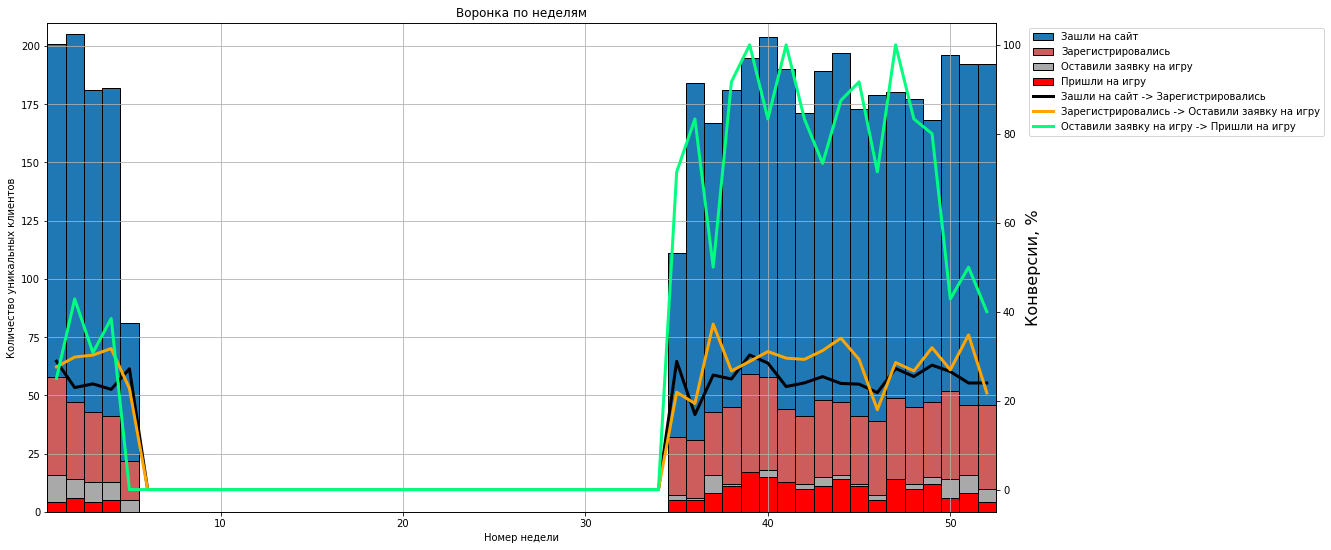

In [17]:
# index = np.arange(13)

plt.figure(figsize=(17,9))
p1 = plt.bar(data_set['week'], data_set['first'], bottom=0, width=1, edgecolor='k', color = 'r')
p2 = plt.bar(data_set['week'], data_set['second'], bottom=data_set['first'], width=1, edgecolor='k', color = 'darkgray')
p3 = plt.bar(data_set['week'], data_set['third'], bottom=data_set['second'] + data_set['first'], width=1, edgecolor='k', color = 'indianred')
p4 = plt.bar(data_set['week'], data_set['fourth'], bottom=data_set['third'] + data_set['second'] + data_set['first'], width=1, edgecolor='k')
plt.ylabel('Количество уникальных клиентов')
plt.xlabel('Номер недели')
plt.title('Воронка по неделям')

plt.ylim(0, 210)
plt.xlim(.5, 52.5)
plt.grid()

# Вторая ось для У (конверсия)
plt.twinx()
plt.ylabel('Конверсии, %', color='black', fontsize= 16 ) 
k1 = plt.plot(data_set['week'], data_set['share_1'], linewidth= 3, color='black')  
k2 = plt.plot(data_set['week'], data_set['share_2'], linewidth= 3,  color='orange')
k3 = plt.plot(data_set['week'], data_set['share_3'], linewidth= 3,  color='springgreen')        
    
plt.legend((p4[0], p3[0], p2[0], p1[0], k1[0], k2[0], k3[0]),('Зашли на сайт', 'Зарегистрировались', 'Оставили заявку на игру',
                                                              'Пришли на игру', 'Зашли на сайт -> Зарегистрировались',
                                                             'Зарегистрировались -> Оставили заявку на игру',
                                                             'Оставили заявку на игру -> Пришли на игру'), bbox_to_anchor=(1.03, 1))    
plt.show()

# Таблица значений количества посетителей по неделям и конверсии

In [18]:

data_all[['share_1']] = data_all[['share_1']].astype(str) +'%'
data_all[['share_2']] = data_all[['share_2']].astype(str) +'%'
data_all[['share_3']] = data_all[['share_3']].astype(str) +'%'

In [19]:
data_all

,Зашли на сайт,Зарегистрировались,Оставили заявку,Пришли на игру,Всего пришли на игру,share_1,share_2,share_3
week,,,,,,,,
1.0,201,58,16,4,6,28.86%,27.59%,25.0%
2.0,205,47,14,6,12,22.93%,29.79%,42.86%
3.0,181,43,13,4,8,23.76%,30.23%,30.77%
4.0,182,41,13,5,13,22.53%,31.71%,38.46%
5.0,81,22,5,0,0,27.16%,22.73%,0.0%
6.0,0,0,0,0,0,0.0%,0.0%,0.0%
7.0,0,0,0,0,0,0.0%,0.0%,0.0%
9.0,0,0,0,0,0,0.0%,0.0%,0.0%
10.0,0,0,0,0,0,0.0%,0.0%,0.0%


## ВЫВОД 

По графикам воронок можно увидеть, что конверсия пользователей, которые оставили заявку на игру, а потом на нее пришли резко падает с декабря по февраль. Возможно, это связано с новогодними праздниками. Или пользователи оставляли заявки на игры, которые еще не прошли. Данных об этих играх в базе еще нет. Это плохо влияет на точность конверсии.

Из-за структуры базы данных нельзя точно отследить посещения сайта пользователем. Хранится только дата последнего визита. Получается, что для одного и того же пользователся нельзя построить воронку по предыдущим месяцам. Это также плохо влияет на точность значений конверсии.

Конверсия 'Зашли на сайт -> Зарегистрировались' стабильно держится на уровне 23%.